#### **PyTorch**

In [1]:
import torch
import torch.nn.functional as F
print(f"PyTorch Version: {torch.__version__}")

import torch
print(f"Cude is available: {torch.cuda.is_available()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.3.0+cu121
Cude is available: True
Device name: NVIDIA A100-SXM4-40GB


#### **Import Other Libraries**

In [2]:
# Standard library imports
import os

# Deep learning libraries
import torch
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, DataCollatorWithPadding

# Text processing libraries
import tiktoken
import csv
import pandas as pd

# Utility libraries
import numpy as np
import random
import math
from tqdm import tqdm
from itertools import chain
from IPython.display import display, Markdown
import textwrap

# Custom libraries  
from llmft.train import DecoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict

# Visualization libraries
import seaborn as sns  # Assuming seaborn is installed

# NLP utility (assuming trics is a library/module)
from trics.nlp.utils import to_markdown

# Configure GPU usage and tokenizer parallelism
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Dataset libraries (can be grouped together)
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

#### **Parameters**

In [3]:
seed = 0
noise = False 
version = 1 
lr = 1e-3 
sample_size = 3000
warmup_ratio = 0.25
batch_size = 8
epochs = 30
patience = 10
gamma = 0.0
prompt = True 
test_size = 0.25

#### **Seed**

In [4]:
np.random.seed(seed)

#### **Set Up Paths**

In [5]:
data_csv = f'./../../../toy-data/exp2/data_{version}.csv'

#### **Set Up Plotting**

In [6]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_24pt/Newsreader_24pt-Bold.ttf


#### **First Stage Function**

In [7]:
conditions_not_covered = [
    "Short-term illnesses",
    "Temporary exhaustion",
    "Behavioral Traits and Conditions",
    "Having a quick temper without any underlying medical condition",
    "Certain Addictions",
    "Substance abuse disorders",
    "good health"
]

conditions_covered = [
    "Mobility impairments",
    "Visual impairments",
    "Hearing impairments",
    "Chronic illnesses",
    "Respiratory disorders",
    "Cardiovascular conditions",
    "Intellectual disabilities",
    "Learning disabilities",
    "Autism spectrum disorders",
    "Psychiatric disorders",
    "Traumatic brain injuries",
    "Alzheimer's disease and other dementias"
]

disabilities = conditions_covered + conditions_not_covered

# Create a list of (0,1)s
severity_indicator = [1 if disability in conditions_covered else 0 for disability in disabilities]

def fstage(var1, var2, var3, var4, var5, var6, var7, var8, var9):
    return 0.02 + 0.35*severity_indicator[var5] + 0.35*var9

#### **Read in Data**

In [8]:
import re 

def remove_newlines(text):
    return re.sub(r'\n+', '', text)

string_b = 'Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.\n\n Description:'
string1 = "\n\n Note: The tenant has access to a free lawyer."
string0 = "\n\n Note: The tenant does not have access to a free lawyer."
if prompt:
    string1 += " Access to a lawyer does not mean the tenant will be represented in court by a lawyer." \
        " If the tenant is given access to a lawyer, they must apply for representation." \
        " Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications." \
        " Providers can differ over what they consider to be a dissability."\
        " If a tenant's application is selected, they must follow-up with the provider to arange for legal representation." \
        " Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation."

# Read in Data Set
df = pd.read_csv(data_csv)
df['Description'] = df['Description'].apply(lambda x: remove_newlines(x))


# Subsample Observations
indices = np.random.choice(df.index, size=sample_size, replace=False)
df = df.loc[indices].reset_index(drop=True)

# Apply First Stage Function
df['FStage_Value'] = df.apply(lambda row: fstage(
                                                 row['Var1'], 
                                                 row['Var2'], 
                                                 row['Var3'], 
                                                 row['Var4'], 
                                                 row['Var5'],
                                                 row['Var6'],
                                                 row['Var7'],
                                                 row['Var8'],
                                                 row['Var9']), axis=1)

# If Noise: Shuffle the first stage values
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)

# Sample Instrumental Values  
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=sample_size)

# Text + Instrument
df['FullDescription'] = np.where(df['Instrument'] == 1,
                             string_b + df['Description'] + string1,
                             string_b + df['Description'] + string0)

# Text + Instrument == 1
df['Treated_FullDescription'] = df.apply(lambda row: string_b + row['Description'].replace("\n", "") + string1, axis=1)

# Text + Instrument == 0
df['Control_FullDescription'] = df.apply(lambda row: string_b + row['Description'].replace("\n", "") + string0, axis=1)

# Sample Treatment Values
df['Treatment'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=sample_size)

# Sample Outcome Values
df['Outcome'] =  (1. +  2.*(df['FStage_Value'] > 0.))*df['Treatment'] + 0.1*np.random.normal(size=sample_size)

#### **Plot**

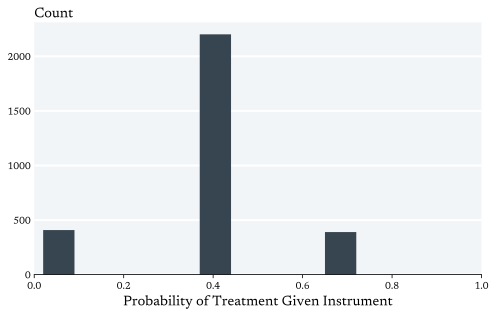

In [9]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.show()

##### **Set Up Device**

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


#### **Qlora**

In [11]:
from peft import LoraConfig, get_peft_model 
from transformers import BitsAndBytesConfig

# ----- QUANTIZATION -------# 
# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = True

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = True

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# ----- LORA -------# 

# lora_config = LoraConfig(
#     r=8,
#     target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
#     task_type="CAUSAL_LM",
# )
additional_modules = ["attn_proj", "ff_proj"]
target_modules = ["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"] + additional_modules

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05, 
    target_modules='all-linear',
    bias="none",
    task_type="CAUSAL_LM",
)

Your GPU supports bfloat16: accelerate training with bf16=True


#### **Instantiate Model**

In [12]:
model_name = "microsoft/Phi-3-mini-4k-instruct"#'meta-llama/Meta-Llama-3-8B-Instruct' #"microsoft/Phi-3-mini-4k-instruct"# #"microsoft/Phi-3-mini-4k-instruct" #meta-llama/Meta-Llama-3-8B-Instruct" 

from transformers.utils import is_flash_attn_2_available
print(is_flash_attn_2_available())
model = AutoModelForCausalLM.from_pretrained(model_name, 
                                            device_map="auto", 
                                            quantization_config=bnb_config, 
                                            trust_remote_code=True,
                                            attn_implementation="flash_attention_2")# So we can do gradient checkpointing
model.config.use_cache = True
model.config.pretraining_tp = 1
model.generation_config.temperature = 0.001
model.enable_input_require_grads()
print(model.generation_config)

model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

True


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": [
    32000,
    32001,
    32007
  ],
  "pad_token_id": 32000,
  "temperature": 0.001
}

trainable params: 25,165,824 || all params: 3,846,245,376 || trainable%: 0.6543
None


#### **Tokenizer**

In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
# Set the padding side to left
tokenizer.padding_side = 'left'

def tokenizer_function(example):
  return tokenizer.apply_chat_template(example["messages"], 
                                                          tokenize=True, 
                                                          add_generation_prompt=False, 
                                                          return_dict=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### **Create Dataset**

In [14]:
if model_name == 'microsoft/Phi-3-mini-4k-instruct':
    # Initialize the dataset list
    dataset = []
    treated_dataset = []
    control_dataset = []

    for index, row in df.iterrows():
        entry = [
            {'content': f"Task: {row['FullDescription']}", 'role': 'user'},
            {'content': 'No' if row['Treatment'] == 0 else 'Yes', 'role': 'assistant'}
        ]

        treated_entry = [
            {'content': f"Task: {row['Treated_FullDescription']}", 'role': 'user'},
            {'content': 'No' if row['Treatment'] == 0 else 'Yes', 'role': 'assistant'}
        ]
        
        control_entry = [
            {'content': f"Task: {row['Control_FullDescription']}", 'role': 'user'},
            {'content': 'No' if row['Treatment'] == 0 else 'Yes', 'role': 'assistant'}
        ]

        dataset.append(entry)
        treated_dataset.append(treated_entry)
        control_dataset.append(control_entry)

    dataset = Dataset.from_dict({'messages': dataset})
    treated_dataset = Dataset.from_dict({'messages': treated_dataset})
    control_dataset = Dataset.from_dict({'messages': control_dataset})

else:
    # Initialize the dataset list
    dataset = []

    for index, row in df.iterrows():
        entry = [
            {'content': 'You are a housing court clerk', 'role': 'system'},
            {'content': f"Task: {row['FullDescription']}", 'role': 'user'},
            {'content': 'No' if row['Treatment'] == 0 else 'Yes', 'role': 'assistant'}
        ]
        dataset.append(entry)

    dataset = Dataset.from_dict({'messages': dataset})

#### **Token Length**

(array([191., 751., 482.,  55.,  95., 616., 653., 141.,  13.,   3.]),
 array([136. , 166.8, 197.6, 228.4, 259.2, 290. , 320.8, 351.6, 382.4,
        413.2, 444. ]),
 <BarContainer object of 10 artists>)

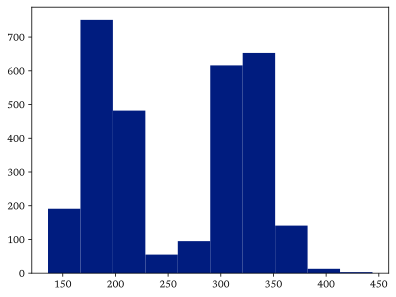

In [15]:
batched_tokens = tokenizer.apply_chat_template(dataset['messages'], tokenize=True, batched=True)
plt.hist(list(map(len, batched_tokens)))

#### **Input Type**

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

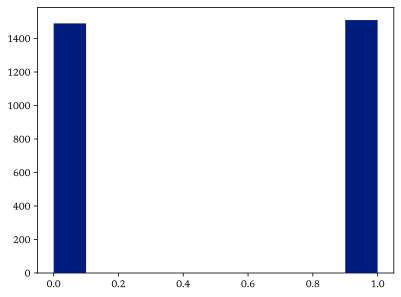

In [16]:
if model_name == 'microsoft/Phi-3-mini-4k-instruct':
    def get_input_id(example):
        example['type_indicator'] = 1 if 'The tenant has access to a free lawyer' in example['messages'][0]['content'] else 0 
        return example
else:
    def get_input_id(example):
        example['type_indicator'] = 1 if 'The tenant has access to a free lawyer' in example['messages'][1]['content'] else 0 
        return example

dataset = dataset.map(get_input_id, batched=False)
treated_dataset = treated_dataset.map(get_input_id, batched=False)
control_dataset = control_dataset.map(get_input_id, batched=False)
plt.hist(dataset['type_indicator'])
plt.show()

In [17]:
tokens = tokenizer.apply_chat_template(dataset['messages'][0], tokenizer=False)
tokenizer.decode(tokens[-1])

'<|end|>'

#### **Output Type**

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

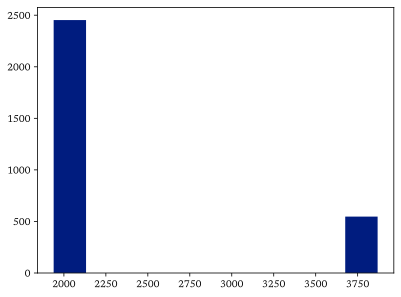

In [18]:
if model_name == 'microsoft/Phi-3-mini-4k-instruct':
    def get_output_id(example):
        string = example['messages'][1]['content']
        example['target_token'] = tokenizer.encode(string, add_special_tokens=False)[0] 
        return example

else:
    def get_output_id(example):
        string = example['messages'][2]['content']
        example['target_token'] = tokenizer.encode(string, add_special_tokens=False)[0] 
        return example

def get_ys_id(example):
    example['yes_token'] = tokenizer.encode('Yes', add_special_tokens=False)[0] 
    return example


dataset = dataset.map(get_output_id, batched=False)
dataset = dataset.map(get_ys_id, batched=False)
dataset = dataset.add_column("fstage", df['FStage_Value'].values.tolist())
dataset = dataset.add_column("outcome", df['Outcome'].values.tolist())

treated_dataset = treated_dataset.map(get_output_id, batched=False)
treated_dataset = treated_dataset.map(get_ys_id, batched=False)
treated_dataset = treated_dataset.add_column("fstage", df['FStage_Value'].values.tolist())
treated_dataset = treated_dataset.add_column("outcome", df['Outcome'].values.tolist())

control_dataset = control_dataset.map(get_output_id, batched=False)
control_dataset = control_dataset.map(get_ys_id, batched=False)
control_dataset = control_dataset.add_column("fstage", df['FStage_Value'].values.tolist())
control_dataset = control_dataset.add_column("outcome", df['Outcome'].values.tolist())

plt.hist(dataset['target_token'])
plt.show()

#### **Data Loaders**

In [19]:
tokenized_dataset = dataset.map(tokenizer_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['messages'])
tokenized_dataset_split = tokenized_dataset.train_test_split(test_size=test_size, seed=42)

tokenized_treated_dataset = treated_dataset.map(tokenizer_function, batched=True)
tokenized_treated_dataset = tokenized_treated_dataset.remove_columns(['messages'])

tokenized_control_dataset = control_dataset.map(tokenizer_function, batched=True)
tokenized_control_dataset = tokenized_control_dataset.remove_columns(['messages'])


all_loader = DataLoader(tokenized_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
treated_loader = DataLoader(tokenized_treated_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
control_loader = DataLoader(tokenized_control_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)

train_loader = DataLoader(tokenized_dataset_split['train'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True)
test_loader = DataLoader(tokenized_dataset_split['test'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer))

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

#### **Optimizer**

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler =transformers.optimization.get_linear_schedule_with_warmup(optimizer,int(warmup_ratio*len(train_loader)*epochs), len(train_loader)*epochs)

#### **Class Weights**

In [21]:
class_weights = torch.tensor([1., 1.], device=device) #torch.tensor([1-n_positive/n_samples, n_positive/n_samples], device=device)
# criterion = FocalLoss(alpha=class_weights, gamma=gamma, mode='output', reduction='none')
# criterion = torch.nn.CrossEntropyLoss(reduction='mean') 

# # Assume 'class_counts' is a list containing the number of samples for each class
# n_samples = len(dataset['train']); print(f"Number of Observations: {n_samples}")
# n_positive = sum(dataset['train']['type_indicator']); print(f"Number of Positive Outcomes: {n_positive}")
# class_weights = torch.tensor([1., 1.], device=device) 
# frac_positive = (n_positive/n_samples)
# class_weights = torch.tensor([1/ (1-frac_positive), 1 / frac_positive], device=device)
# class_weights = class_weights/sum(class_weights)
criterion = FocalLoss(alpha=class_weights, gamma=gamma, mode='input')
print(criterion.gamma)
print(f"Class Weights: {class_weights}")

0.0
Class Weights: tensor([1., 1.], device='cuda:0')


#### **Trainer**

In [22]:
yuri = DecoderTrainer(model,
                    tokenizer,
                    optimizer, 
                    scheduler,
                    criterion, 
                    device, 
                    verbose=False, 
                    threshold=2)

print(yuri.verbose)
early_stopping = EarlyStopping(patience)

False


#### **Training**

In [23]:
evaluation_losses = [yuri.evaluate(test_loader)[1]]
training_losses = [yuri.evaluate(train_loader)[1]]
lr_history = [yuri.optimizer.state_dict()['param_groups'][0]['lr']]
#recall_history = [yuri.compute_recall(test_loader)]
pbar =  tqdm(range(epochs), desc=f'Epoch: 0, Train Loss: {training_losses[0]:.3f}, Val Loss: {evaluation_losses[0]:.3f}')  #,  rYes: {recall_history[0][1]:.3f}')

for epoch in pbar:
    train_loss = yuri.train(train_loader)
    training_losses.append(train_loss[1])
    val_loss = yuri.evaluate(test_loader)
    evaluation_losses.append(val_loss[1])
    #recall = yuri.compute_recall(test_loader)
    #recall_history.append(recall)

    pbar.set_description(f'Epoch: {epoch + 1}, Train Loss: {train_loss[1]:.4f}, Val Loss: {val_loss[1]:.4f}')# , rYes: {recall[1]:.3f}')

        # Call early stopping
    early_stopping(val_loss[1], model, epoch)
    if early_stopping.early_stop:
        print("***Early stopping***")
        print(f"Min Validation Loss: {early_stopping.best_epoch}")
        print(f"Current Epoch: {epoch}")
        break

yuri.model.load_state_dict(torch.load('checkpoint.pt'))

Epoch: 1, Train Loss: 0.6494, Val Loss: 0.3175:   3%|▎         | 1/30 [08:34<4:08:31, 514.21s/it]


KeyboardInterrupt: 

#### **Losses**

In [ ]:
plt.plot(training_losses, label='Training')
plt.plot(evaluation_losses, label='Validation')
plt.legend()
plt.show()

In [ ]:
# for batch in train_loader:
#     input_ids, logits, type_indicator, target_token = yuri.process_batch(batch, 'yes_token')
#     loss, log_prob_target = yuri.compute_loss(input_ids, logits, type_indicator, target_token)
#     print(target_token)
#     print(tokenizer.decode(target_token))
#     generated_ids = yuri.model.generate(
#                         input_ids=input_ids[:,:-2],
#                         max_new_tokens=2,
#                         temperature=0.001)  # Ensure temperature is set here)
#     decoded_batch_texts = yuri.tokenizer.batch_decode(generated_ids, skip_special_tokens=False)
#     print(decoded_batch_texts)
#     break



In [ ]:
_, _, log_probs, indicators, target, fstage, outcomes, texts = yuri.evaluate(data_loader=all_loader, token_type='yes_token', return_decoded_text=True, max_new_tokens=2)


In [ ]:
_, _, log_probs_treatment, _, _, _, _ = yuri.evaluate(data_loader=treated_loader, token_type='yes_token', return_decoded_text=False, max_new_tokens=2)
_, _, log_probs_control, _, _, _, _ = yuri.evaluate(data_loader=control_loader, token_type='yes_token', return_decoded_text=False, max_new_tokens=2)


In [ ]:
plt.plot(np.exp(log_probs_treatment))
plt.plot(np.exp(log_probs_control))
plt.show()

In [ ]:
Y = np.array(outcomes)
residuals = np.exp(log_probs).reshape(-1,1) - (0.5*np.exp(log_probs_treatment).reshape(-1,1) + 0.5*np.exp(log_probs_control).reshape(-1,1) )

In [ ]:
plt.hist(residuals)

In [ ]:
est = np.linalg.lstsq( np.hstack((residuals, np.ones_like(residuals))), Y)[0]
est

In [ ]:
plt.scatter(np.array(fstage)*np.array(indicators.to('cpu')), np.exp(log_probs))
plt.plot([0,1], [0, 1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [ ]:
x = tokenizer.apply_chat_template(dataset['messages'][1], tokenize=True, skip_special_tokens=False)
tokenizer.decode(x[-2])

In [ ]:
for i, (j, k, l) in enumerate(zip(log_probs, target, texts)):
    print(f"Target : {k}, {torch.exp(j):.4f}")
    display(to_markdown(l))
    if i > 10:
        break

In [ ]:
dataset

In [ ]:
qs = np.linspace(0, 1, 100)
ys1 = np.quantile(np.exp(log_probs)[indicators.to('cpu') == 1], qs)
ys2 = np.quantile(df['FStage_Value'].values, qs)
plt.plot(qs, ys1)
plt.plot(qs, ys2)
plt.ylim(0, 1)
plt.show()

In [ ]:
# Ensure probabilities are within (0, 1) to avoid log(0)
epsilon = 1e-15
probabilities = np.clip(df['FStage_Value'].values*df['Instrument'].values, epsilon, 1 - epsilon)

# Compute binary cross-entropy loss
bce_loss = -np.mean(df['Treatment'].values * np.log(probabilities) + (1 - df['Treatment'].values) * np.log(1 - probabilities))

print(f'Binary Cross-Entropy Loss: {bce_loss}')

In [ ]:
# Assuming you have the same tokenizer

# Convert text to token IDs
yes_token_id = tokenizer.convert_tokens_to_ids('Yes')
print(f'Token ID for "Yes" using convert_tokens_to_ids: {yes_token_id}')

# Decode the token ID back to text
decoded_text_8241 = tokenizer.decode([8241])
decoded_text_3869 = tokenizer.decode([3869])

# Print the decoded texts with their ASCII values
print(f'Decoded text for token ID 8241: {decoded_text_8241} (ASCII: {[ord(c) for c in decoded_text_8241]})')
print(f'Decoded text for token ID 3869: {decoded_text_3869} (ASCII: {[ord(c) for c in decoded_text_3869]})')

# Check the lengths of the decoded texts
print(f'Length of decoded text for token ID 8241: {len(decoded_text_8241)}')
print(f'Length of decoded text for token ID 3869: {len(decoded_text_3869)}')

# Verify if the decoded texts are identical
print(f'Decoded texts are identical: {decoded_text_8241 == decoded_text_3869}')


In [ ]:
#plt.plot(yes_probs)
plt.plot(yes_sampeled[0].cpu())

In [ ]:
probs

In [ ]:
generated_outputs = model.generate(
    batch["input_ids"], 
    max_new_tokens=50, 
    do_sample=True, 
    output_scores=True,
    return_dict_in_generate=True
)

In [ ]:
to_markdown(s)

In [ ]:
generated_outputs.sequences

In [ ]:
to_markdown(tokenizer.batch_decode(generated_outputs.sequences, skip_special_tokens=True)[0])

In [ ]:
generated_outputs[0]